In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
import random
import pickle5 as pickle
import time

import matplotlib.pyplot as plt
%matplotlib inline

from helpers import *

import cv2
from scipy.ndimage import median_filter
from skimage.transform import resize as sk_resize
from skimage.util import img_as_ubyte
from skimage.morphology import skeletonize, thin

In [2]:
fig_size = [5, 5]
cmap = 'inferno'

In [3]:
# load data
with open('../data/WM-clean.pkl', "rb") as fh:
    raw_data = pickle.load(fh)
print(f'Raw data shape: {raw_data.shape}')

Raw data shape: (172950, 11)


In [4]:
# add index column to identify specific wafers 
raw_data.reset_index(inplace=True)
raw_data = raw_data.rename(columns={'index':'ID'})

# add detection model labels
raw_data['detectLabels'] = raw_data['failureType'].apply(lambda x: 0 if x == 'none' else 1)

# add classification model labels
fail_dict = {'none': 8, 'Loc': 0, 'Edge-Loc': 1, 'Center': 2, 'Edge-Ring': 3, 
             'Scratch': 4, 'Random': 5, 'Near-full': 6, 'Donut': 7}
raw_data['classifyLabels'] = raw_data['failureType'].apply(lambda x: fail_dict[x])

raw_data.head()

,ID,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset,detectLabels,classifyLabels
0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,8
1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0,8
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,8
4,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,8


In [5]:
# remove test set
data = raw_data[raw_data.dataset != 'test'].reset_index(drop=True)
print(f'Train/dev data shape: {data.shape}')

# picked out "good" and "bad" examples of each failure type
good_indices = [81093, 23883, 146546, 21963, 21504, 81735, 14937, 8777, 17502]
bad_indices = [84792, 19099, 71986, 23280, 123406, 98254, 98185, 17960, 105729]

# IDs of "good" and "bad" examples
good = [data.ID[i] for i in good_indices]
bad = [data.ID[i] for i in bad_indices]

# create subset of data df for vis
vis_df = data.loc[good_indices + bad_indices].reset_index(drop=True)

Train/dev data shape: (147007, 14)


In [6]:
# resize to 224x224
start = time.time()

def resize(x):
    y = sk_resize(x, [224,224])
    new_y = img_as_ubyte(y)
    return new_y
    
vis_df['waferMap224'] = vis_df.waferMap.apply(lambda x: resize(x))

# check that resizing worked
walltime = time.time() - start
print(f'Wall time: {walltime:.3f} seconds')
print(vis_df.waferMap224[2].shape)

Wall time: 0.041 seconds
(224, 224)


In [7]:
# resize to 224x224
# apply 7x7 median filter
start = time.time()

def preprocess(x):
    y = sk_resize(x, [224,224])
    new_y = img_as_ubyte(y)
    z = cv2.medianBlur(new_y, 7)
    return z
    
vis_df['filterMap7'] = vis_df.waferMap.apply(lambda x: preprocess(x))

# check that resizing worked
walltime = time.time() - start
print(f'Wall time: {walltime:.3f} seconds')
print(vis_df.filterMap7[2].shape)

Wall time: 0.069 seconds
(224, 224)


In [8]:
# resize to 224x224 and binarize
start = time.time()

def binarize(x):
    y = sk_resize(x, [224,224])
    new_y = img_as_ubyte(y)
    ret, thresh_img = cv2.threshold(new_y, 1, 1, cv2.THRESH_BINARY)
    return thresh_img
    
vis_df['binaryMap'] = vis_df.waferMap.apply(lambda x: binarize(x))

# check that resizing worked
walltime = time.time() - start
walltime = time.time() - start
print(f'Wall time: {walltime:.3f} seconds')
print(np.unique(vis_df.binaryMap[2]))

Wall time: 0.043 seconds
[0 1]


In [9]:
# apply thinning n=2
start = time.time()

vis_df['thinMap2'] = vis_df.binaryMap.apply(lambda x: thin(x, 2))

walltime = time.time() - start
print(f'Wall time: {walltime:.3f} seconds')

Wall time: 0.061 seconds


#### Good plots

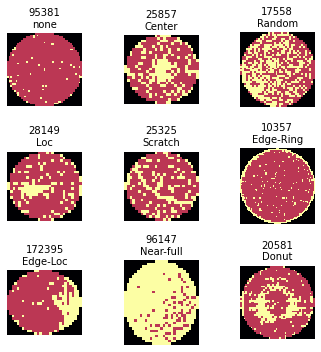

In [10]:
plot_list(vis_df, good, fig_size=fig_size, col='waferMap', cmap=cmap, mode='id')

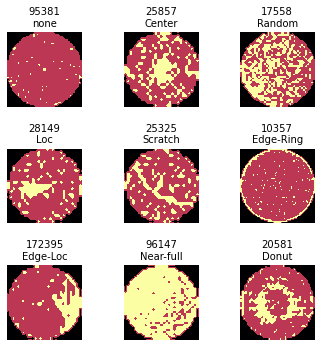

In [11]:
plot_list(vis_df, good, fig_size=fig_size, col='waferMap224', cmap=cmap, mode='id')

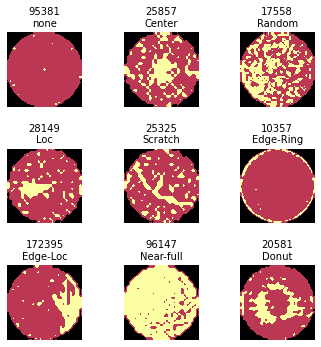

In [12]:
plot_list(vis_df, good, fig_size=fig_size, col='filterMap7', cmap=cmap, mode='id')

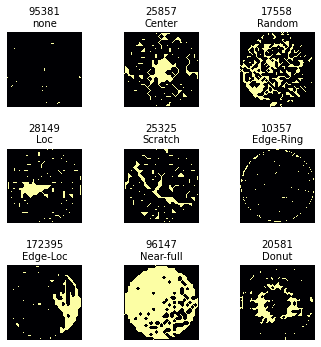

In [13]:
plot_list(vis_df, good, fig_size=fig_size, col='thinMap2', cmap=cmap, mode='id')

#### Bad plots

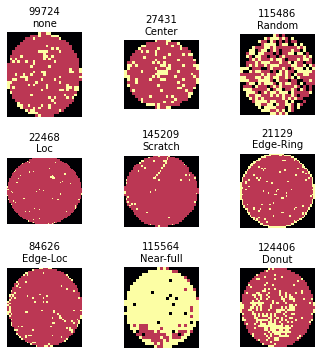

In [14]:
plot_list(vis_df, bad, fig_size=fig_size, col='waferMap', cmap=cmap, mode='id')

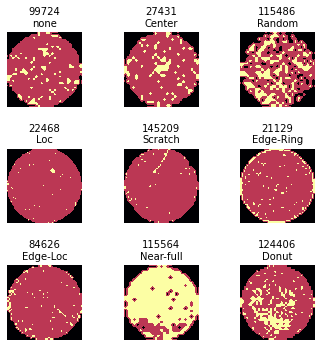

In [15]:
plot_list(vis_df, bad, fig_size=fig_size, col='waferMap224', cmap=cmap, mode='id')

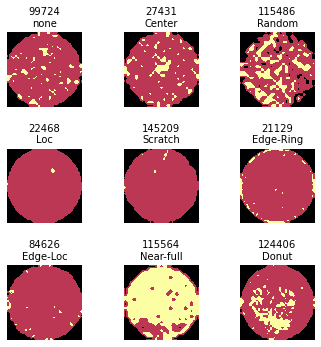

In [16]:
plot_list(vis_df, bad, fig_size=fig_size, col='filterMap7', cmap=cmap, mode='id')

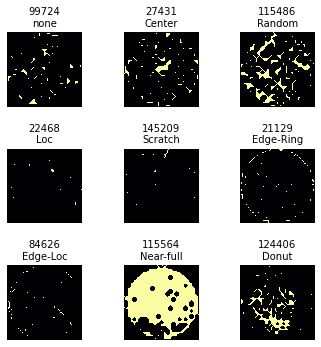

In [17]:
plot_list(vis_df, bad, fig_size=fig_size, col='thinMap2', cmap=cmap, mode='id')